In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# R2 값, 결정계수 계산
from sklearn.metrics import r2_score

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor



# 시각화
import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
from pylab import rcParams

font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
# w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
w = pd.read_csv('d:/project/contest/data/processed/날씨_ver071915.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '선케어'만 빼서 df생성
item = '선케어'
grouped_by = 'date'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not','미세', '초미세', '공기상태',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
lv_day_w = day_lv_grouped_w_sns_item[selected_cols]

In [5]:
# MAD적용
lv_day_w['outlier'] = pd.DataFrame(mad_based_outlier(lv_day_w['qty']))
lv_day_w = lv_day_w.loc[lv_day_w.outlier==False]

In [6]:
# list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
list_col = ['temp', 'cloud', 'wind','lgt_time',
            'rain_or_not', 'snow_or_not', '공기상태'] #+'rain_or_not', 'snow_or_not'
lowVIF(w,20,list_col)

,VIF_Factor,features
0,1.239620,snow_or_not
1,2.479988,rain_or_not
2,3.114369,공기상태
3,4.013218,temp
4,6.725926,cloud
5,8.084050,lgt_time
6,9.334878,wind


In [7]:
train_data = lv_day_w.loc[lv_day_w.date.between('2016-01-01','2017-12-31')]
test_data = lv_day_w.loc[lv_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만
combined = lv_day_w.loc[:,list_col]
target = lv_day_w.loc[:,'qty']
Xy = pd.concat([target,combined], axis=1)

In [8]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [9]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 7
오브젝트형 자료 컬럼 갯수 : 0


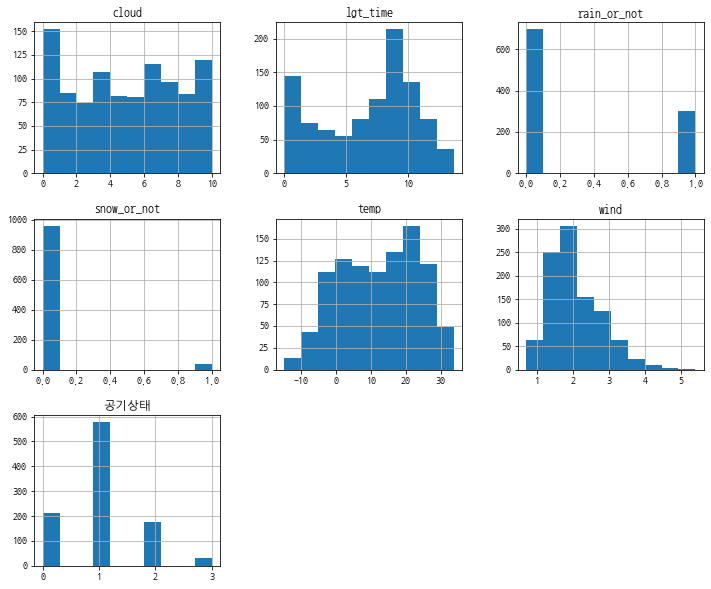

In [10]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

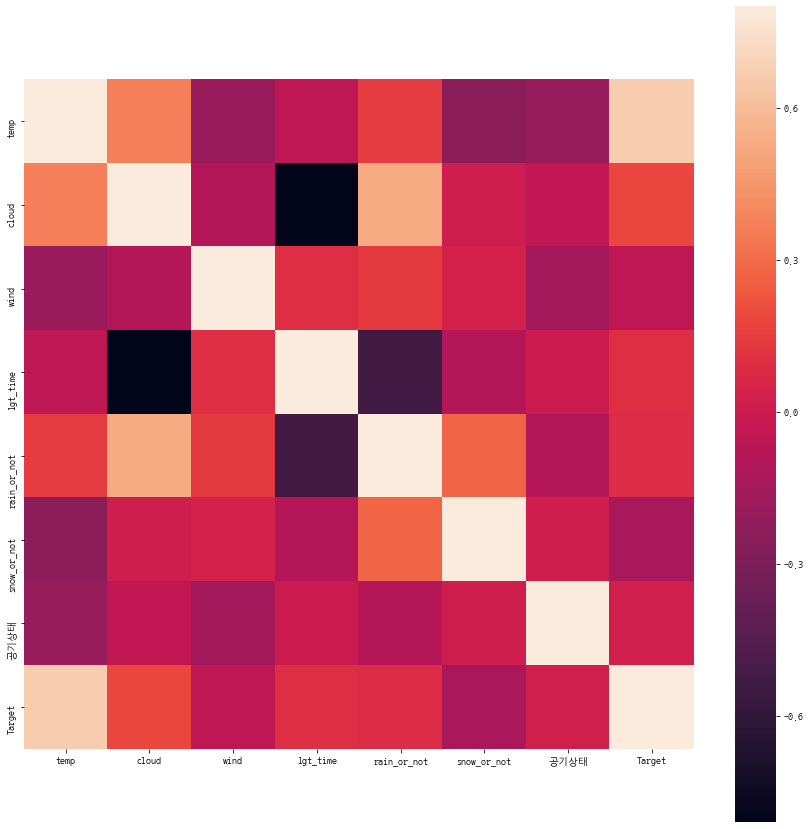

In [11]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [12]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
#### 내가 '공기상태'라는 컬럼이 사실은 category형이라는것을 알기에 직접 dummy컬럼 생성
airCondition_dummies = pd.get_dummies(combined['공기상태'],prefix='공기상태')
combined = pd.concat([combined, airCondition_dummies], axis=1)
combined.drop(['공기상태'],axis = 1 , inplace=True)
######################################################################################
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 10 개의 columns이 있었습니다.


In [13]:
combined.head(1)

,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2,공기상태_3
0,1.2,7.0,1.6,2.1,0,0,0,0,1,0


In [14]:
# 공기상태_0,공기상태_1,공기상태_2가 전부 0이면,   공기상태_3이 1이란 소리고
#                                                               공기상태가 '매우나쁨' 임을 추정할수 있다.
# 그런이유로 공기상태_3삭제
combined.drop(['공기상태_3'],axis = 1 , inplace=True)

In [15]:
combined.columns

Index(['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not',
       '공기상태_0', '공기상태_1', '공기상태_2'],
      dtype='object')

In [16]:
Xy = pd.concat([target,combined], axis=1)
# Xy.head(1)

In [17]:
# 첫 2년 : 732 일
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 9)

In [18]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0722 14:48:17.935636 13048 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 14:48:17.973495 13048 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 14:48:17.977485 13048 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0722 14:48:18.037324 13048 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5'

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [20]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0722 14:48:18.273804 13048 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0722 14:48:18.388493 13048 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/1000
585/585 [==============================] - 0s 502us/step - loss: 3191.9584 - mean_absolute_error: 3191.9584 - val_loss: 1275.4971 - val_mean_absolute_error: 1275.4971

Epoch 00001: val_loss improved from inf to 1275.49711, saving model to 선케어date-Weights-001--1275.49711-cat02-vf05.hdf5
Epoch 2/1000
585/585 [==============================] - 0s 77us/step - loss: 2696.6754 - mean_absolute_error: 2696.6754 - val_loss: 489.7998 - val_mean_absolute_error: 489.7998

Epoch 00002: val_loss improved from 1275.49711 to 489.79983, saving model to 선케어date-Weights-002--489.79983-cat02-vf05.hdf5
Epoch 3/1000
585/585 [==============================] - 0s 78us/step - loss: 1431.6961 - mean_absolute_error: 1431.6961 - val_loss: 674.5157 - val_mean_absolute_error: 674.5157

Epoch 00003: val_loss did not improve from 489.79983
Epoch 4/1000
585/585 [==============================] - 0s 72us/step - loss: 1327.1610 - mean_absolute_error: 1327.1610 -


Epoch 00035: val_loss did not improve from 489.79983
Epoch 36/1000
585/585 [==============================] - 0s 82us/step - loss: 1132.5202 - mean_absolute_error: 1132.5202 - val_loss: 748.1251 - val_mean_absolute_error: 748.1251

Epoch 00036: val_loss did not improve from 489.79983
Epoch 37/1000
585/585 [==============================] - 0s 87us/step - loss: 1152.6771 - mean_absolute_error: 1152.6771 - val_loss: 665.9746 - val_mean_absolute_error: 665.9746

Epoch 00037: val_loss did not improve from 489.79983
Epoch 38/1000
585/585 [==============================] - 0s 82us/step - loss: 1140.0449 - mean_absolute_error: 1140.0449 - val_loss: 710.7290 - val_mean_absolute_error: 710.7290

Epoch 00038: val_loss did not improve from 489.79983
Epoch 39/1000
585/585 [==============================] - 0s 84us/step - loss: 1173.6887 - mean_absolute_error: 1173.6887 - val_loss: 704.2940 - val_mean_absolute_error: 704.2940

Epoch 00039: val_loss did not improve from 489.79983
Epoch 40/1000
585/

585/585 [==============================] - 0s 92us/step - loss: 1106.5448 - mean_absolute_error: 1106.5448 - val_loss: 707.2727 - val_mean_absolute_error: 707.2727

Epoch 00071: val_loss did not improve from 489.79983
Epoch 72/1000
585/585 [==============================] - 0s 89us/step - loss: 1105.2569 - mean_absolute_error: 1105.2569 - val_loss: 679.6174 - val_mean_absolute_error: 679.6174

Epoch 00072: val_loss did not improve from 489.79983
Epoch 73/1000
585/585 [==============================] - 0s 97us/step - loss: 1107.1001 - mean_absolute_error: 1107.1001 - val_loss: 665.1137 - val_mean_absolute_error: 665.1137

Epoch 00073: val_loss did not improve from 489.79983
Epoch 74/1000
585/585 [==============================] - 0s 89us/step - loss: 1100.9158 - mean_absolute_error: 1100.9158 - val_loss: 659.8057 - val_mean_absolute_error: 659.8057

Epoch 00074: val_loss did not improve from 489.79983
Epoch 75/1000
585/585 [==============================] - 0s 87us/step - loss: 1094.437

585/585 [==============================] - 0s 95us/step - loss: 1058.0764 - mean_absolute_error: 1058.0764 - val_loss: 673.0741 - val_mean_absolute_error: 673.0741

Epoch 00106: val_loss did not improve from 489.79983
Epoch 107/1000
585/585 [==============================] - 0s 106us/step - loss: 1053.3064 - mean_absolute_error: 1053.3064 - val_loss: 701.7845 - val_mean_absolute_error: 701.7845

Epoch 00107: val_loss did not improve from 489.79983
Epoch 108/1000
585/585 [==============================] - 0s 109us/step - loss: 1050.9304 - mean_absolute_error: 1050.9304 - val_loss: 661.5293 - val_mean_absolute_error: 661.5293

Epoch 00108: val_loss did not improve from 489.79983
Epoch 109/1000
585/585 [==============================] - 0s 99us/step - loss: 1051.7204 - mean_absolute_error: 1051.7204 - val_loss: 604.0085 - val_mean_absolute_error: 604.0085

Epoch 00109: val_loss did not improve from 489.79983
Epoch 110/1000
585/585 [==============================] - 0s 99us/step - loss: 10

585/585 [==============================] - 0s 114us/step - loss: 991.8126 - mean_absolute_error: 991.8126 - val_loss: 647.4359 - val_mean_absolute_error: 647.4359

Epoch 00141: val_loss did not improve from 489.79983
Epoch 142/1000
585/585 [==============================] - 0s 114us/step - loss: 974.7103 - mean_absolute_error: 974.7103 - val_loss: 628.9936 - val_mean_absolute_error: 628.9936

Epoch 00142: val_loss did not improve from 489.79983
Epoch 143/1000
585/585 [==============================] - 0s 123us/step - loss: 997.2780 - mean_absolute_error: 997.2780 - val_loss: 604.3002 - val_mean_absolute_error: 604.3002

Epoch 00143: val_loss did not improve from 489.79983
Epoch 144/1000
585/585 [==============================] - 0s 111us/step - loss: 981.2645 - mean_absolute_error: 981.2645 - val_loss: 660.2714 - val_mean_absolute_error: 660.2714

Epoch 00144: val_loss did not improve from 489.79983
Epoch 145/1000
585/585 [==============================] - 0s 111us/step - loss: 1000.05

585/585 [==============================] - 0s 124us/step - loss: 966.2673 - mean_absolute_error: 966.2673 - val_loss: 621.2318 - val_mean_absolute_error: 621.2318

Epoch 00176: val_loss did not improve from 489.79983
Epoch 177/1000
585/585 [==============================] - 0s 131us/step - loss: 983.2581 - mean_absolute_error: 983.2581 - val_loss: 628.6172 - val_mean_absolute_error: 628.6172

Epoch 00177: val_loss did not improve from 489.79983
Epoch 178/1000
585/585 [==============================] - 0s 116us/step - loss: 985.5001 - mean_absolute_error: 985.5001 - val_loss: 550.2236 - val_mean_absolute_error: 550.2236

Epoch 00178: val_loss did not improve from 489.79983
Epoch 179/1000
585/585 [==============================] - 0s 106us/step - loss: 961.8940 - mean_absolute_error: 961.8940 - val_loss: 626.5628 - val_mean_absolute_error: 626.5628

Epoch 00179: val_loss did not improve from 489.79983
Epoch 180/1000
585/585 [==============================] - 0s 121us/step - loss: 961.850

585/585 [==============================] - 0s 123us/step - loss: 925.0010 - mean_absolute_error: 925.0010 - val_loss: 572.2770 - val_mean_absolute_error: 572.2770

Epoch 00211: val_loss did not improve from 489.79983
Epoch 212/1000
585/585 [==============================] - 0s 113us/step - loss: 913.6495 - mean_absolute_error: 913.6495 - val_loss: 589.9358 - val_mean_absolute_error: 589.9358

Epoch 00212: val_loss did not improve from 489.79983
Epoch 213/1000
585/585 [==============================] - 0s 111us/step - loss: 903.0756 - mean_absolute_error: 903.0756 - val_loss: 559.6955 - val_mean_absolute_error: 559.6955

Epoch 00213: val_loss did not improve from 489.79983
Epoch 214/1000
585/585 [==============================] - 0s 124us/step - loss: 961.7155 - mean_absolute_error: 961.7155 - val_loss: 568.9130 - val_mean_absolute_error: 568.9130

Epoch 00214: val_loss did not improve from 489.79983
Epoch 215/1000
585/585 [==============================] - 0s 123us/step - loss: 932.546

585/585 [==============================] - 0s 124us/step - loss: 932.2750 - mean_absolute_error: 932.2750 - val_loss: 606.7341 - val_mean_absolute_error: 606.7341

Epoch 00246: val_loss did not improve from 489.79983
Epoch 247/1000
585/585 [==============================] - 0s 131us/step - loss: 906.3663 - mean_absolute_error: 906.3663 - val_loss: 574.4354 - val_mean_absolute_error: 574.4354

Epoch 00247: val_loss did not improve from 489.79983
Epoch 248/1000
585/585 [==============================] - 0s 138us/step - loss: 912.1121 - mean_absolute_error: 912.1121 - val_loss: 687.5107 - val_mean_absolute_error: 687.5107

Epoch 00248: val_loss did not improve from 489.79983
Epoch 249/1000
585/585 [==============================] - 0s 118us/step - loss: 888.9712 - mean_absolute_error: 888.9712 - val_loss: 569.2520 - val_mean_absolute_error: 569.2520

Epoch 00249: val_loss did not improve from 489.79983
Epoch 250/1000
585/585 [==============================] - 0s 121us/step - loss: 895.180

585/585 [==============================] - 0s 145us/step - loss: 887.7369 - mean_absolute_error: 887.7369 - val_loss: 584.1552 - val_mean_absolute_error: 584.1552

Epoch 00281: val_loss did not improve from 489.79983
Epoch 282/1000
585/585 [==============================] - 0s 124us/step - loss: 868.6572 - mean_absolute_error: 868.6572 - val_loss: 577.3471 - val_mean_absolute_error: 577.3471

Epoch 00282: val_loss did not improve from 489.79983
Epoch 283/1000
585/585 [==============================] - 0s 124us/step - loss: 869.5788 - mean_absolute_error: 869.5788 - val_loss: 601.1643 - val_mean_absolute_error: 601.1643

Epoch 00283: val_loss did not improve from 489.79983
Epoch 284/1000
585/585 [==============================] - 0s 138us/step - loss: 872.7838 - mean_absolute_error: 872.7838 - val_loss: 551.6742 - val_mean_absolute_error: 551.6742

Epoch 00284: val_loss did not improve from 489.79983
Epoch 285/1000
585/585 [==============================] - 0s 142us/step - loss: 899.959

585/585 [==============================] - 0s 152us/step - loss: 886.7830 - mean_absolute_error: 886.7830 - val_loss: 571.1547 - val_mean_absolute_error: 571.1547

Epoch 00316: val_loss did not improve from 489.79983
Epoch 317/1000
585/585 [==============================] - 0s 133us/step - loss: 854.7447 - mean_absolute_error: 854.7447 - val_loss: 564.8235 - val_mean_absolute_error: 564.8235

Epoch 00317: val_loss did not improve from 489.79983
Epoch 318/1000
585/585 [==============================] - 0s 135us/step - loss: 875.0469 - mean_absolute_error: 875.0469 - val_loss: 569.9767 - val_mean_absolute_error: 569.9767

Epoch 00318: val_loss did not improve from 489.79983
Epoch 319/1000
585/585 [==============================] - 0s 133us/step - loss: 920.3716 - mean_absolute_error: 920.3716 - val_loss: 549.8269 - val_mean_absolute_error: 549.8269

Epoch 00319: val_loss did not improve from 489.79983
Epoch 320/1000
585/585 [==============================] - 0s 133us/step - loss: 889.285

585/585 [==============================] - 0s 124us/step - loss: 866.0770 - mean_absolute_error: 866.0770 - val_loss: 590.9248 - val_mean_absolute_error: 590.9248

Epoch 00351: val_loss did not improve from 489.79983
Epoch 352/1000
585/585 [==============================] - 0s 133us/step - loss: 848.6896 - mean_absolute_error: 848.6896 - val_loss: 576.7838 - val_mean_absolute_error: 576.7838

Epoch 00352: val_loss did not improve from 489.79983
Epoch 353/1000
585/585 [==============================] - 0s 136us/step - loss: 857.1456 - mean_absolute_error: 857.1456 - val_loss: 637.0190 - val_mean_absolute_error: 637.0190

Epoch 00353: val_loss did not improve from 489.79983
Epoch 354/1000
585/585 [==============================] - 0s 167us/step - loss: 868.3789 - mean_absolute_error: 868.3789 - val_loss: 567.0299 - val_mean_absolute_error: 567.0299

Epoch 00354: val_loss did not improve from 489.79983
Epoch 355/1000
585/585 [==============================] - 0s 147us/step - loss: 843.038

585/585 [==============================] - 0s 128us/step - loss: 845.5049 - mean_absolute_error: 845.5049 - val_loss: 601.8131 - val_mean_absolute_error: 601.8131

Epoch 00386: val_loss did not improve from 489.79983
Epoch 387/1000
585/585 [==============================] - 0s 138us/step - loss: 866.5041 - mean_absolute_error: 866.5041 - val_loss: 591.7091 - val_mean_absolute_error: 591.7091

Epoch 00387: val_loss did not improve from 489.79983
Epoch 388/1000
585/585 [==============================] - 0s 133us/step - loss: 850.6917 - mean_absolute_error: 850.6917 - val_loss: 655.3030 - val_mean_absolute_error: 655.3030

Epoch 00388: val_loss did not improve from 489.79983
Epoch 389/1000
585/585 [==============================] - 0s 131us/step - loss: 850.0273 - mean_absolute_error: 850.0273 - val_loss: 593.1569 - val_mean_absolute_error: 593.1569

Epoch 00389: val_loss did not improve from 489.79983
Epoch 390/1000
585/585 [==============================] - 0s 143us/step - loss: 859.852

585/585 [==============================] - 0s 140us/step - loss: 839.6040 - mean_absolute_error: 839.6040 - val_loss: 615.8416 - val_mean_absolute_error: 615.8416

Epoch 00421: val_loss did not improve from 489.79983
Epoch 422/1000
585/585 [==============================] - 0s 113us/step - loss: 834.4496 - mean_absolute_error: 834.4496 - val_loss: 599.2171 - val_mean_absolute_error: 599.2171

Epoch 00422: val_loss did not improve from 489.79983
Epoch 423/1000
585/585 [==============================] - 0s 147us/step - loss: 835.1683 - mean_absolute_error: 835.1683 - val_loss: 651.7748 - val_mean_absolute_error: 651.7748

Epoch 00423: val_loss did not improve from 489.79983
Epoch 424/1000
585/585 [==============================] - 0s 145us/step - loss: 810.6427 - mean_absolute_error: 810.6427 - val_loss: 607.0367 - val_mean_absolute_error: 607.0367

Epoch 00424: val_loss did not improve from 489.79983
Epoch 425/1000
585/585 [==============================] - ETA: 0s - loss: 846.8728 - me

585/585 [==============================] - 0s 131us/step - loss: 834.7638 - mean_absolute_error: 834.7638 - val_loss: 646.1978 - val_mean_absolute_error: 646.1978

Epoch 00456: val_loss did not improve from 489.79983
Epoch 457/1000
585/585 [==============================] - 0s 130us/step - loss: 810.6631 - mean_absolute_error: 810.6631 - val_loss: 611.8157 - val_mean_absolute_error: 611.8157

Epoch 00457: val_loss did not improve from 489.79983
Epoch 458/1000
585/585 [==============================] - 0s 136us/step - loss: 796.3095 - mean_absolute_error: 796.3095 - val_loss: 613.4637 - val_mean_absolute_error: 613.4637

Epoch 00458: val_loss did not improve from 489.79983
Epoch 459/1000
585/585 [==============================] - 0s 124us/step - loss: 825.5923 - mean_absolute_error: 825.5923 - val_loss: 594.6380 - val_mean_absolute_error: 594.6380

Epoch 00459: val_loss did not improve from 489.79983
Epoch 460/1000
585/585 [==============================] - 0s 136us/step - loss: 834.537

585/585 [==============================] - 0s 133us/step - loss: 783.6400 - mean_absolute_error: 783.6400 - val_loss: 669.6787 - val_mean_absolute_error: 669.6787

Epoch 00491: val_loss did not improve from 489.79983
Epoch 492/1000
585/585 [==============================] - 0s 128us/step - loss: 816.8187 - mean_absolute_error: 816.8187 - val_loss: 633.6704 - val_mean_absolute_error: 633.6704

Epoch 00492: val_loss did not improve from 489.79983
Epoch 493/1000
585/585 [==============================] - 0s 136us/step - loss: 787.4490 - mean_absolute_error: 787.4490 - val_loss: 701.3660 - val_mean_absolute_error: 701.3660

Epoch 00493: val_loss did not improve from 489.79983
Epoch 494/1000
585/585 [==============================] - 0s 147us/step - loss: 809.9278 - mean_absolute_error: 809.9278 - val_loss: 616.9179 - val_mean_absolute_error: 616.9179

Epoch 00494: val_loss did not improve from 489.79983
Epoch 495/1000
585/585 [==============================] - 0s 131us/step - loss: 813.273

585/585 [==============================] - 0s 133us/step - loss: 867.8788 - mean_absolute_error: 867.8788 - val_loss: 623.2793 - val_mean_absolute_error: 623.2793

Epoch 00526: val_loss did not improve from 489.79983
Epoch 527/1000
585/585 [==============================] - 0s 136us/step - loss: 780.3398 - mean_absolute_error: 780.3398 - val_loss: 753.6598 - val_mean_absolute_error: 753.6598

Epoch 00527: val_loss did not improve from 489.79983
Epoch 528/1000
585/585 [==============================] - 0s 138us/step - loss: 815.0913 - mean_absolute_error: 815.0913 - val_loss: 696.9054 - val_mean_absolute_error: 696.9054

Epoch 00528: val_loss did not improve from 489.79983
Epoch 529/1000
585/585 [==============================] - 0s 148us/step - loss: 801.4045 - mean_absolute_error: 801.4045 - val_loss: 624.2450 - val_mean_absolute_error: 624.2450

Epoch 00529: val_loss did not improve from 489.79983
Epoch 530/1000
585/585 [==============================] - 0s 143us/step - loss: 794.763

585/585 [==============================] - 0s 152us/step - loss: 800.6766 - mean_absolute_error: 800.6766 - val_loss: 685.6648 - val_mean_absolute_error: 685.6648

Epoch 00561: val_loss did not improve from 489.79983
Epoch 562/1000
585/585 [==============================] - 0s 150us/step - loss: 772.9316 - mean_absolute_error: 772.9316 - val_loss: 638.7479 - val_mean_absolute_error: 638.7479

Epoch 00562: val_loss did not improve from 489.79983
Epoch 563/1000
585/585 [==============================] - 0s 148us/step - loss: 767.4244 - mean_absolute_error: 767.4244 - val_loss: 683.1468 - val_mean_absolute_error: 683.1468

Epoch 00563: val_loss did not improve from 489.79983
Epoch 564/1000
585/585 [==============================] - 0s 147us/step - loss: 764.7060 - mean_absolute_error: 764.7060 - val_loss: 699.6863 - val_mean_absolute_error: 699.6863

Epoch 00564: val_loss did not improve from 489.79983
Epoch 565/1000
585/585 [==============================] - 0s 150us/step - loss: 795.106

585/585 [==============================] - 0s 123us/step - loss: 775.5027 - mean_absolute_error: 775.5027 - val_loss: 678.7087 - val_mean_absolute_error: 678.7087

Epoch 00596: val_loss did not improve from 489.79983
Epoch 597/1000
585/585 [==============================] - 0s 152us/step - loss: 792.8705 - mean_absolute_error: 792.8705 - val_loss: 758.6554 - val_mean_absolute_error: 758.6554

Epoch 00597: val_loss did not improve from 489.79983
Epoch 598/1000
585/585 [==============================] - 0s 126us/step - loss: 775.1757 - mean_absolute_error: 775.1757 - val_loss: 722.8242 - val_mean_absolute_error: 722.8242

Epoch 00598: val_loss did not improve from 489.79983
Epoch 599/1000
585/585 [==============================] - 0s 138us/step - loss: 746.2893 - mean_absolute_error: 746.2893 - val_loss: 718.0454 - val_mean_absolute_error: 718.0454

Epoch 00599: val_loss did not improve from 489.79983
Epoch 600/1000
585/585 [==============================] - 0s 135us/step - loss: 741.685

585/585 [==============================] - 0s 199us/step - loss: 760.1480 - mean_absolute_error: 760.1480 - val_loss: 716.5545 - val_mean_absolute_error: 716.5545

Epoch 00631: val_loss did not improve from 489.79983
Epoch 632/1000
585/585 [==============================] - 0s 182us/step - loss: 751.3475 - mean_absolute_error: 751.3475 - val_loss: 730.2561 - val_mean_absolute_error: 730.2561

Epoch 00632: val_loss did not improve from 489.79983
Epoch 633/1000
585/585 [==============================] - 0s 177us/step - loss: 732.0336 - mean_absolute_error: 732.0336 - val_loss: 748.5283 - val_mean_absolute_error: 748.5283

Epoch 00633: val_loss did not improve from 489.79983
Epoch 634/1000
585/585 [==============================] - 0s 179us/step - loss: 747.8856 - mean_absolute_error: 747.8856 - val_loss: 668.2721 - val_mean_absolute_error: 668.2721

Epoch 00634: val_loss did not improve from 489.79983
Epoch 635/1000
585/585 [==============================] - 0s 186us/step - loss: 747.724

585/585 [==============================] - 0s 153us/step - loss: 722.2107 - mean_absolute_error: 722.2107 - val_loss: 774.2842 - val_mean_absolute_error: 774.2842

Epoch 00666: val_loss did not improve from 489.79983
Epoch 667/1000
585/585 [==============================] - 0s 145us/step - loss: 732.2078 - mean_absolute_error: 732.2078 - val_loss: 677.8686 - val_mean_absolute_error: 677.8686

Epoch 00667: val_loss did not improve from 489.79983
Epoch 668/1000
585/585 [==============================] - 0s 150us/step - loss: 790.6103 - mean_absolute_error: 790.6103 - val_loss: 676.8521 - val_mean_absolute_error: 676.8521

Epoch 00668: val_loss did not improve from 489.79983
Epoch 669/1000
585/585 [==============================] - 0s 159us/step - loss: 785.4082 - mean_absolute_error: 785.4082 - val_loss: 721.0940 - val_mean_absolute_error: 721.0940

Epoch 00669: val_loss did not improve from 489.79983
Epoch 670/1000
585/585 [==============================] - 0s 167us/step - loss: 733.355

585/585 [==============================] - 0s 140us/step - loss: 739.2766 - mean_absolute_error: 739.2766 - val_loss: 707.1950 - val_mean_absolute_error: 707.1950

Epoch 00701: val_loss did not improve from 489.79983
Epoch 702/1000
585/585 [==============================] - 0s 145us/step - loss: 756.2270 - mean_absolute_error: 756.2270 - val_loss: 809.1463 - val_mean_absolute_error: 809.1463

Epoch 00702: val_loss did not improve from 489.79983
Epoch 703/1000
585/585 [==============================] - 0s 170us/step - loss: 722.1099 - mean_absolute_error: 722.1099 - val_loss: 718.3526 - val_mean_absolute_error: 718.3526

Epoch 00703: val_loss did not improve from 489.79983
Epoch 704/1000
585/585 [==============================] - 0s 184us/step - loss: 722.7510 - mean_absolute_error: 722.7510 - val_loss: 686.8602 - val_mean_absolute_error: 686.8602

Epoch 00704: val_loss did not improve from 489.79983
Epoch 705/1000
585/585 [==============================] - 0s 174us/step - loss: 758.320

585/585 [==============================] - 0s 121us/step - loss: 710.1279 - mean_absolute_error: 710.1279 - val_loss: 752.0590 - val_mean_absolute_error: 752.0590

Epoch 00736: val_loss did not improve from 489.79983
Epoch 737/1000
585/585 [==============================] - 0s 133us/step - loss: 700.5193 - mean_absolute_error: 700.5193 - val_loss: 743.4950 - val_mean_absolute_error: 743.4950

Epoch 00737: val_loss did not improve from 489.79983
Epoch 738/1000
585/585 [==============================] - 0s 136us/step - loss: 701.3129 - mean_absolute_error: 701.3129 - val_loss: 711.7394 - val_mean_absolute_error: 711.7394

Epoch 00738: val_loss did not improve from 489.79983
Epoch 739/1000
585/585 [==============================] - 0s 150us/step - loss: 694.8062 - mean_absolute_error: 694.8062 - val_loss: 747.4873 - val_mean_absolute_error: 747.4873

Epoch 00739: val_loss did not improve from 489.79983
Epoch 740/1000
585/585 [==============================] - 0s 142us/step - loss: 694.166

585/585 [==============================] - 0s 147us/step - loss: 685.7314 - mean_absolute_error: 685.7314 - val_loss: 706.7952 - val_mean_absolute_error: 706.7952

Epoch 00771: val_loss did not improve from 489.79983
Epoch 772/1000
585/585 [==============================] - 0s 169us/step - loss: 682.5469 - mean_absolute_error: 682.5469 - val_loss: 730.2406 - val_mean_absolute_error: 730.2406

Epoch 00772: val_loss did not improve from 489.79983
Epoch 773/1000
585/585 [==============================] - 0s 157us/step - loss: 694.9141 - mean_absolute_error: 694.9141 - val_loss: 801.6754 - val_mean_absolute_error: 801.6754

Epoch 00773: val_loss did not improve from 489.79983
Epoch 774/1000
585/585 [==============================] - 0s 167us/step - loss: 705.6203 - mean_absolute_error: 705.6203 - val_loss: 748.2618 - val_mean_absolute_error: 748.2618

Epoch 00774: val_loss did not improve from 489.79983
Epoch 775/1000
585/585 [==============================] - 0s 162us/step - loss: 701.445

585/585 [==============================] - 0s 153us/step - loss: 690.5921 - mean_absolute_error: 690.5921 - val_loss: 714.4301 - val_mean_absolute_error: 714.4301

Epoch 00806: val_loss did not improve from 489.79983
Epoch 807/1000
585/585 [==============================] - 0s 130us/step - loss: 674.5944 - mean_absolute_error: 674.5944 - val_loss: 797.0177 - val_mean_absolute_error: 797.0177

Epoch 00807: val_loss did not improve from 489.79983
Epoch 808/1000
585/585 [==============================] - 0s 160us/step - loss: 693.8277 - mean_absolute_error: 693.8277 - val_loss: 740.7281 - val_mean_absolute_error: 740.7281

Epoch 00808: val_loss did not improve from 489.79983
Epoch 809/1000
585/585 [==============================] - 0s 147us/step - loss: 700.9086 - mean_absolute_error: 700.9086 - val_loss: 798.7472 - val_mean_absolute_error: 798.7472

Epoch 00809: val_loss did not improve from 489.79983
Epoch 810/1000
585/585 [==============================] - 0s 153us/step - loss: 692.177

585/585 [==============================] - 0s 155us/step - loss: 671.5435 - mean_absolute_error: 671.5435 - val_loss: 713.3906 - val_mean_absolute_error: 713.3906

Epoch 00841: val_loss did not improve from 489.79983
Epoch 842/1000
585/585 [==============================] - 0s 145us/step - loss: 681.2058 - mean_absolute_error: 681.2058 - val_loss: 835.2312 - val_mean_absolute_error: 835.2312

Epoch 00842: val_loss did not improve from 489.79983
Epoch 843/1000
585/585 [==============================] - 0s 159us/step - loss: 679.2455 - mean_absolute_error: 679.2455 - val_loss: 757.8734 - val_mean_absolute_error: 757.8734

Epoch 00843: val_loss did not improve from 489.79983
Epoch 844/1000
585/585 [==============================] - 0s 174us/step - loss: 670.0014 - mean_absolute_error: 670.0014 - val_loss: 823.5658 - val_mean_absolute_error: 823.5658

Epoch 00844: val_loss did not improve from 489.79983
Epoch 845/1000
585/585 [==============================] - 0s 153us/step - loss: 672.052

585/585 [==============================] - 0s 150us/step - loss: 717.3258 - mean_absolute_error: 717.3258 - val_loss: 845.6172 - val_mean_absolute_error: 845.6172

Epoch 00876: val_loss did not improve from 489.79983
Epoch 877/1000
585/585 [==============================] - 0s 142us/step - loss: 700.3615 - mean_absolute_error: 700.3615 - val_loss: 732.8491 - val_mean_absolute_error: 732.8491

Epoch 00877: val_loss did not improve from 489.79983
Epoch 878/1000
585/585 [==============================] - 0s 160us/step - loss: 664.1744 - mean_absolute_error: 664.1744 - val_loss: 744.9401 - val_mean_absolute_error: 744.9401

Epoch 00878: val_loss did not improve from 489.79983
Epoch 879/1000
585/585 [==============================] - 0s 155us/step - loss: 671.6222 - mean_absolute_error: 671.6222 - val_loss: 792.2435 - val_mean_absolute_error: 792.2435

Epoch 00879: val_loss did not improve from 489.79983
Epoch 880/1000
585/585 [==============================] - 0s 159us/step - loss: 679.219

585/585 [==============================] - 0s 138us/step - loss: 697.1515 - mean_absolute_error: 697.1515 - val_loss: 773.9055 - val_mean_absolute_error: 773.9055

Epoch 00911: val_loss did not improve from 489.79983
Epoch 912/1000
585/585 [==============================] - 0s 136us/step - loss: 681.1412 - mean_absolute_error: 681.1412 - val_loss: 759.4857 - val_mean_absolute_error: 759.4857

Epoch 00912: val_loss did not improve from 489.79983
Epoch 913/1000
585/585 [==============================] - 0s 142us/step - loss: 680.0841 - mean_absolute_error: 680.0841 - val_loss: 800.9576 - val_mean_absolute_error: 800.9576

Epoch 00913: val_loss did not improve from 489.79983
Epoch 914/1000
585/585 [==============================] - 0s 176us/step - loss: 686.3514 - mean_absolute_error: 686.3514 - val_loss: 738.7592 - val_mean_absolute_error: 738.7592

Epoch 00914: val_loss did not improve from 489.79983
Epoch 915/1000
585/585 [==============================] - 0s 160us/step - loss: 694.753

585/585 [==============================] - 0s 194us/step - loss: 616.1365 - mean_absolute_error: 616.1365 - val_loss: 828.6892 - val_mean_absolute_error: 828.6892

Epoch 00946: val_loss did not improve from 489.79983
Epoch 947/1000
585/585 [==============================] - 0s 186us/step - loss: 655.9070 - mean_absolute_error: 655.9070 - val_loss: 808.6290 - val_mean_absolute_error: 808.6290

Epoch 00947: val_loss did not improve from 489.79983
Epoch 948/1000
585/585 [==============================] - 0s 174us/step - loss: 619.8238 - mean_absolute_error: 619.8238 - val_loss: 783.7105 - val_mean_absolute_error: 783.7105

Epoch 00948: val_loss did not improve from 489.79983
Epoch 949/1000
585/585 [==============================] - 0s 176us/step - loss: 653.1875 - mean_absolute_error: 653.1875 - val_loss: 825.5460 - val_mean_absolute_error: 825.5460

Epoch 00949: val_loss did not improve from 489.79983
Epoch 950/1000
585/585 [==============================] - 0s 169us/step - loss: 684.814

585/585 [==============================] - 0s 167us/step - loss: 616.5657 - mean_absolute_error: 616.5657 - val_loss: 820.3981 - val_mean_absolute_error: 820.3981

Epoch 00981: val_loss did not improve from 489.79983
Epoch 982/1000
585/585 [==============================] - 0s 165us/step - loss: 606.5949 - mean_absolute_error: 606.5949 - val_loss: 815.6895 - val_mean_absolute_error: 815.6895

Epoch 00982: val_loss did not improve from 489.79983
Epoch 983/1000
585/585 [==============================] - 0s 162us/step - loss: 621.9344 - mean_absolute_error: 621.9344 - val_loss: 793.2148 - val_mean_absolute_error: 793.2148

Epoch 00983: val_loss did not improve from 489.79983
Epoch 984/1000
585/585 [==============================] - 0s 167us/step - loss: 642.9341 - mean_absolute_error: 642.9341 - val_loss: 833.6524 - val_mean_absolute_error: 833.6524

Epoch 00984: val_loss did not improve from 489.79983
Epoch 985/1000
585/585 [==============================] - 0s 152us/step - loss: 616.091

In [24]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = '선케어date-Weights-002--489.79983-cat02-vf05.hdf5'
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [25]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']

print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))
    
# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

columns_in_data = list(train_X.columns)
customF = formulaGen(target='qty',ind_features=columns_in_data)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )
print('검증세트점수 : {:.3f}'.format( r2_score(val_y, olsModel.predict(val_X))   ) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.926
검증세트점수 : 0.556
XGBoost을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.796
검증세트점수 : 0.522
LinearRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.527
검증세트점수 : 0.466
RidgeRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.518
검증세트점수 : 0.469
LassoRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.527
검증세트점수 : 0.466
OLS을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.527
검증세트점수 : 0.466


In [46]:
print(item, 'ols model')
# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud
columns_in_data = ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not',
                   '공기상태_0', '공기상태_1', '공기상태_2']
# formulaGen은 단순 1차 다항식을 제조해준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
customF = 'qty ~ I(temp**2) + temp'
# customF = formulaGen(target='qty',ind_features=columns_in_data)

olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()

print('사람이 직접 식을 때려 박았을때 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X))) )


olsModel.summary()

선케어 ols model
사람이 직접 식을 때려 박았을때 : 0.501


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     395.7
Date:                Mon, 22 Jul 2019   Prob (F-statistic):          4.38e-117
Time:                        14:57:04   Log-Likelihood:                -6405.0
No. Observations:                 732   AIC:                         1.282e+04
Df Residuals:                     729   BIC:                         1.283e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1316.5078     78.848     16.697      0.000    1161.711    1471.304
I(temp ** 2)     4.3190      0.481      8.983      0.000       3.375       5.263
temp            37.3745     11.601      3.222      0.001      14.600      60.149
==============================================================================
Omnibus:                       58.214   Durbin-Watson:                   0.412
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.516
Skew:                           0.621   Prob(JB):                     1.99e-18
Kurtosis:                       4.063   Cond. No.                         523.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
#             '공기상태_0', '공기상태_1', '공기상태_2']
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
            '공기상태']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = lv_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

ValueError: Error when checking input: expected dense_1_input to have shape (9,) but got array with shape (12,)

In [28]:
# 예측률 계산
# https://yamalab.tistory.com/46
# RMSE (Root Mean Squared Error) : 
# OLS 추정에서 일반적인 표준 오차이다. 예측 대상의 scale(단위 크기)에 주의해야하는 단점이 있다. 
# MSE는 root를 수식에서 제외, SSE는 root와 분모를 제외한 수식으로, SE가 붙은 척도들은 거기서 거기인 척도들이라고 보면 된다.
# 다만 디테일한 사용법에 차이가 있을 뿐.

# MAPE (Mean Absolute Percentage Error) :

# 위 방법의 단점을 보완한 것이다. 
# At는 실제값, Ft는 예측값인데, 이를 At로 나누어서 오차를 절대적 크기로 보는것이 아닌 비율의 크기로 보고자 하는 것이 핵심이다.
# 이 방법은 At가 0에 가까울수록 비정상적인 값이 나온다는 단점이 있다.

# mre가 0에 가까울수록 좋은 모델
result_df['mape_keras'] = abs((result_df.qty - result_df.keras_qty) / result_df.qty )
result_df['mape_rf'] = abs((result_df.qty - result_df.rf_qty) / result_df.qty )
result_df['mape_xgb'] = abs((result_df.qty - result_df.xgb_qty) / result_df.qty )
result_df['mape_lin'] = abs((result_df.qty - result_df.lin_qty) / result_df.qty )
result_df['mape_ridge'] = abs((result_df.qty - result_df.ridge_qty) / result_df.qty )
result_df['mape_lasso'] = abs((result_df.qty - result_df.lasso_qty) / result_df.qty )
result_df['mape_ols'] = abs((result_df.qty - result_df.ols_qty) / result_df.qty )

print('Keras 인공 신경망 모델 MAPE \t: {:<.2f}'.format(result_df['mape_keras'].sum() / result_df.shape[0] ))
# print('RandomForest 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_rf'].sum() / result_df.shape[0] ))
# print('XGBoosting  모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_xgb'].sum() / result_df.shape[0] ))
print('Linear 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lin'].sum() / result_df.shape[0] ))
print('Ridge 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_ridge'].sum() / result_df.shape[0] ))
print('Lasso 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lasso'].sum() / result_df.shape[0] ))
print('OLS 모델 MAPE \t\t\t: {:<.2f}'.format(result_df['mape_ols'].sum() / result_df.shape[0] ))

Keras 인공 신경망 모델 MAPE 	: 0.42
Linear 모델 MAPE 		: 0.59
Ridge 모델 MAPE 		: 0.59
Lasso 모델 MAPE 		: 0.59
OLS 모델 MAPE 			: 0.59


In [29]:
w_seoul.head(1)
w_seoul.shape
result_date_col = result_df.date
result_date_col.shape


(996,)

In [30]:
Xy['공기상태_3'] = Xy[["공기상태_0",'공기상태_1','공기상태_2']].sum(axis=1)
Xy['공기상태_3'] = Xy['공기상태_3'].apply(lambda x : 1 if x==0 else 0)
Xy['date'] = result_date_col

XyAndPm10 = pd.merge(Xy, w_seoul[['date','PM10']], on='date', how='left')
XyAndPm10.head(1)

,qty,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2,공기상태_3,date,PM10
0,689,1.2,7.0,1.6,2.1,0,0,0,0,1,0,2016-01-01,68.6965


In [31]:
print(Xy.shape)
print(result_df.shape)

(996, 12)
(996, 16)


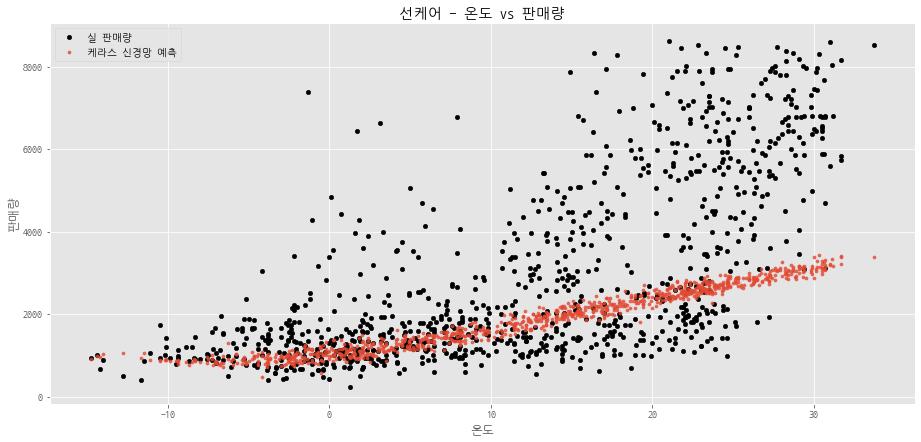

In [48]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_3','aircon',
#                                                     'date','PM10']
n=1
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
# plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.title('%s - %s vs 판매량' % (item, '온도') )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=20, c='k')
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
# plt.xlabel('{}'.format(Xy.columns[n]))
plt.xlabel('온도')

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
figure_name = 'D:/project/contest/ppt/picture/%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()

In [33]:
def airconall(x):
    if x[0]==1:
        return '좋음'
    elif x[1]==1:
        return '보통'
    elif x[2]==1:
        return '나쁨'
    elif x[3]==1:
        return '매우나쁨'

Xy['aircon'] =Xy[['공기상태_0','공기상태_1','공기상태_2','공기상태_3']].apply(airconall, axis=1)

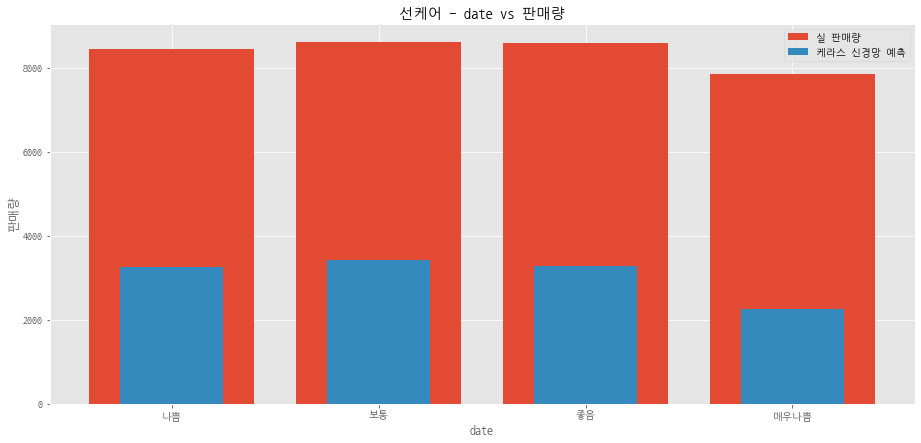

In [34]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_2', 'aircon']
# 1~11
n=11
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )

ind = np.arange(4)
plt.bar(Xy.aircon,result_df.qty, label = '실 판매량')
plt.bar(Xy.aircon,result_df.keras_qty, label = '케라스 신경망 예측',width = 0.5)
# plt.bar(Xy.aircon,result_df.rf_qty, label = 'RandomForest 예측')
# plt.bar(Xy.aircon,result_df.xgb_qty, label = 'XGBoosting 예측')
# plt.bar(Xy.aircon,result_df.lin_qty, label = '선형 예측')
# plt.bar(Xy.aircon,result_df.ridge_qty, label = 'Ridge 예측')
# plt.bar(Xy.aircon,result_df.ols_qty, label = 'OLS 예측')

# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

In [35]:
tt = ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']
print(tt)

['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']


In [36]:
Xy.head(2)
# result_df.head(2)
result_Xy = pd.concat([result_df, Xy[tt]],axis=1)
result_Xy.head(2)

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_ridge,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon
0,2016-01-01,689,996.906433,820.0,1185.808350,918.282944,1169.422392,919.755666,918.282944,0.446889,...,0.697275,0.334914,0.332776,1.2,7.0,1.6,2.1,0,0,나쁨
1,2016-01-02,831,1393.290771,1061.4,1514.370239,1862.964395,2025.454160,1863.910446,1862.964395,0.676644,...,1.437370,1.242973,1.241834,5.7,7.8,2.0,3.6,0,0,보통


In [37]:
result_Xy.columns

Index(['date', 'qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 'ridge_qty',
       'lasso_qty', 'ols_qty', 'mape_keras', 'mape_rf', 'mape_xgb', 'mape_lin',
       'mape_ridge', 'mape_lasso', 'mape_ols', 'temp', 'cloud', 'wind',
       'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon'],
      dtype='object')

In [38]:
def tempCat(x):
    if x < -10:
        return 0
    elif x < 0:
        return 1
    elif x < 10:
        return 2
    elif x < 20:
        return 3
    elif x < 30:
        return 4
    else:
        return 5
    
w_seoul['temp_cat'] = w_seoul.temp.apply(tempCat)
XyAndPm10 = pd.merge(result_Xy, w_seoul[['date','temp_cat']], on='date', how='left')
XyAndPm10.head()

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon,temp_cat
0,2016-01-01,689,996.906433,820.0,1185.808350,918.282944,1169.422392,919.755666,918.282944,0.446889,...,0.334914,0.332776,1.2,7.0,1.6,2.1,0,0,나쁨,2
1,2016-01-02,831,1393.290771,1061.4,1514.370239,1862.964395,2025.454160,1863.910446,1862.964395,0.676644,...,1.242973,1.241834,5.7,7.8,2.0,3.6,0,0,보통,2
2,2016-01-03,615,1334.788208,1019.0,1651.423218,1755.026597,1902.126050,1756.292948,1755.026597,1.170387,...,1.855761,1.853702,6.5,7.5,1.8,2.2,0,0,나쁨,2
3,2016-01-04,688,1340.779175,1175.1,1491.242920,2117.094276,2136.523740,2117.479023,2117.094276,0.948807,...,2.077731,2.077172,2.0,4.4,3.1,8.6,0,0,나쁨,2
4,2016-01-05,651,982.604248,662.4,1226.362061,1058.564594,1266.738667,1059.217348,1058.564594,0.509377,...,0.627062,0.626059,-2.7,3.4,2.3,7.9,0,0,보통,1


In [39]:
p_df = pd.pivot_table(XyAndPm10[['date','qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 
                                 'ridge_qty','lasso_qty', 'ols_qty', 'temp_cat']],
                     values = ['qty', 'keras_qty', 'rf_qty', 'xgb_qty', 
                               'lin_qty', 'ridge_qty','lasso_qty', 'ols_qty'],
                     index=['temp_cat'],
                     aggfunc = np.sum)
p_df = p_df.iloc[:,[4,0,1,2,3,5,6,7]]
p_df

,qty,keras_qty,lasso_qty,lin_qty,ols_qty,rf_qty,ridge_qty,xgb_qty
temp_cat,,,,,,,,
0,12690,12322.770508,-3.517753e+03,-3.525991e+03,-3.525991e+03,12597.6,7.037369e+02,1.326105e+04
1,208148,149277.140625,1.363509e+05,1.363306e+05,1.363306e+05,212055.6,1.669928e+05,2.075824e+05
2,437714,328163.687500,4.780296e+05,4.780320e+05,4.780320e+05,418490.4,5.020760e+05,4.092812e+05
3,720963,511479.000000,8.355262e+05,8.355636e+05,8.355636e+05,711552.8,8.233284e+05,7.026237e+05
4,1393214,789926.437500,1.269712e+06,1.269620e+06,1.269620e+06,1351558.7,1.238006e+06,1.324142e+06
5,189530,89666.468750,1.582029e+05,1.582053e+05,1.582053e+05,186513.7,1.502739e+05,1.878222e+05


In [40]:
# 8개 판매량

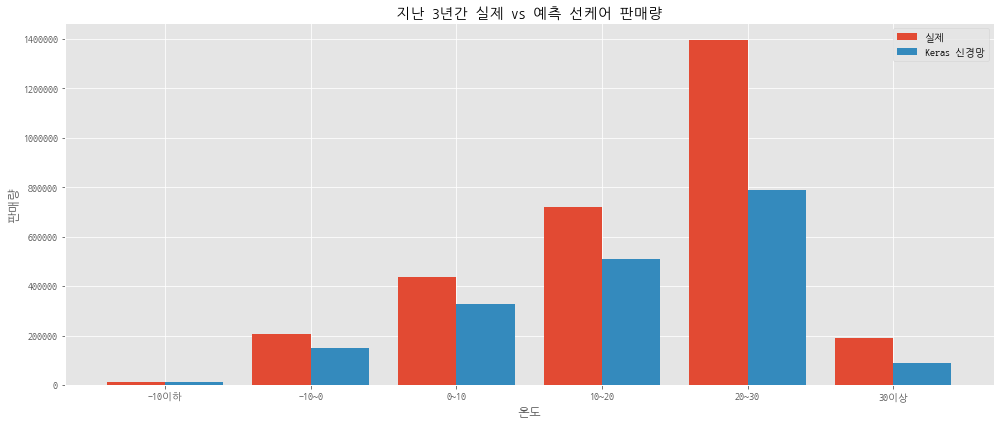

In [41]:
# 사이즈 변경 
rcParams['figure.figsize'] = 14, 6

# 공기상태 길이 만큼 x축 칸 생성
ind = np.arange(len(p_df.index))
# 바의 너비 설정
width = 0.4

# 한 그래프에 여러 값의 바그래프를 넣기 위한 그래프 객체 생성
fig, ax = plt.subplots()

# 각각의 그래프 생성
rects1 = ax.bar(ind - width/2, p_df.qty, width, label = '실제')
rects2 = ax.bar(ind + width/2, p_df.keras_qty, width, label = 'Keras 신경망')
# rects3 = ax.bar(ind - width*2, p_df.lasso_qty, width, label = 'Lasso')
# rects4 = ax.bar(ind - width*1, p_df.lin_qty, width, label = 'Linear')
# rects5 = ax.bar(ind + width*0, p_df.ols_qty, width, label = 'OLS')
# rects6 = ax.bar(ind + width*1, p_df.rf_qty, width, label = 'RandomForest')
# rects7 = ax.bar(ind + width*2, p_df.ridge_qty, width, label = 'Ridge')
# rects8 = ax.bar(ind + width*3, p_df.xgb_qty, width, label = 'XGB', color = 'green')

# 제목
ax.set_title('지난 3년간 실제 vs 예측 %s 판매량'%item)

# y축
ax.set_ylabel('판매량')

# x축
ax.set_xticks(ind)

# x 값 이름
ax.set_xticklabels(('-10이하','-10~0','0~10','10~20','20~30','30이상'))
ax.set_xlabel('온도')

# 범례
ax.legend()

fig.tight_layout()
figure_name = 'D:/project/contest/ppt/picture/실제vs예측_%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()